<a href="https://colab.research.google.com/github/Vitky2/data_analysis/blob/hw_2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Данные
1. В работе будет использоваться датасет machine_temperature_system_failure

In [ ]:
# !pip install pandas numpy matplotlib keras

Подгружаем библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from etna.datasets import TSDataset
from etna.models.nn import DeepARNativeModel, RNNModel
from etna.metrics import MAE

from etna.datasets.tsdataset import TSDataset
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform, LagTransform, LinearTrendTransform, StandardScalerTransform
from etna.metrics import SMAPE, MAPE, MAE
from etna.analysis import plot_backtest
from etna.models import SeasonalMovingAverageModel
from etna.models.nn import DeepARModel, RNNModel
from etna.models.nn.utils import PytorchForecastingDatasetBuilder

from pytorch_forecasting.data import GroupNormalizer

Установка seed для воспроизводимости

In [ ]:
np.random.seed(52)

In [ ]:
# Функция для загрузки и подготовки данных

def load_data(file_path):
    data = pd.read_csv(file_path)
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    return data

In [ ]:
# Функция для визуализации временного ряда
def plot_time_series(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['value'], label='Значение')
    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

## Визуализируем данные

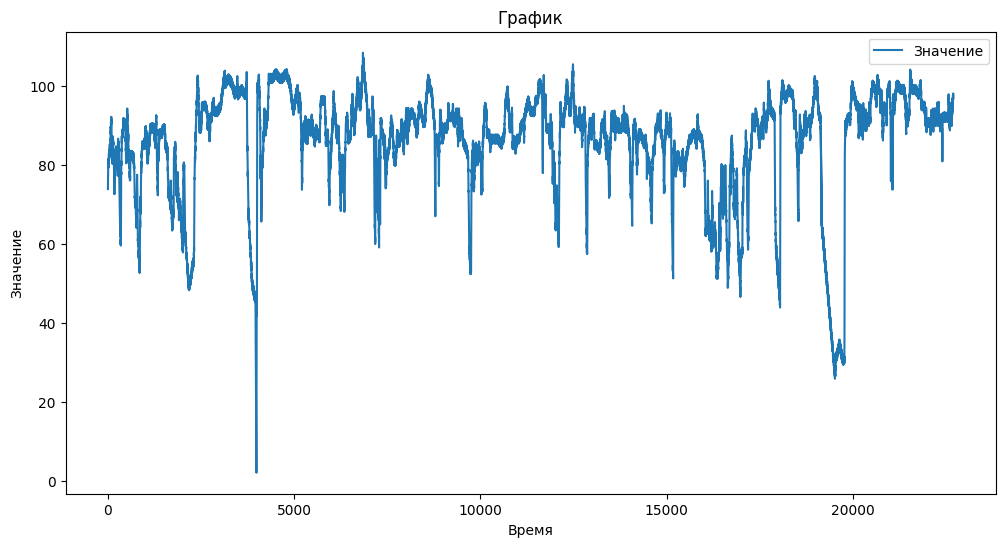

In [ ]:
# Загрузка данных
data = load_data('machine_temperature_system_failure.csv')
plot_time_series(data, 'График')
data.info()

## Сделаем train/test split

In [ ]:
# Train/Test Split
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  22695 non-null  datetime64[ns]
 1   value      22695 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 354.7 KB


## Выберем метрику

In [ ]:
# Функция метрики smape
def smape(y_true, y_pred):
    """Calculates the Symmetric Mean Absolute Percentage Error (SMAPE)"""
    denominator = np.abs(y_true) + np.abs(y_pred)
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # Избегаем деления на ноль
    return 100 * np.mean(diff)

# Прогнозирование

## Бейзлайн

Построим бейзлайн в виде наивного прогноза

In [ ]:
# Бейзлайн
baseline = train['value'].iloc[-1]  # Наивный прогноз
test['Baseline'] = baseline

<ipython-input-11-1cc07f438da7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Baseline'] = baseline


Визуализируем результаты работы модели и произведём замеры качества с выбранной метрикой

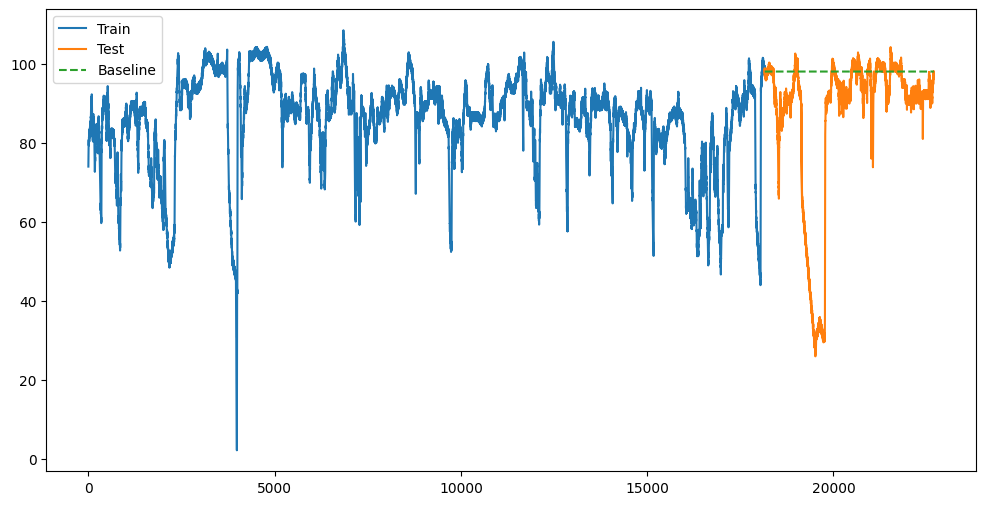


SMAPE Baseline: 8.00%


In [ ]:
# Визуализация бейзлайна
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['value'], label='Train')
plt.plot(test.index, test['value'], label='Test')
plt.plot(test.index, test['Baseline'], label='Baseline', linestyle='--')
plt.legend()
plt.show()

# Замеры качества бейзлайна
smape_baseline = smape(test['value'], test['Baseline'])
print(f'\nSMAPE Baseline: {smape_baseline:.2f}%')

## Статическая модель

Для модуля арима вычиляем p-значение по тесту Дикки-Фуллера, сначала оно >0.5 поэтому дифференции ряд и после этого он становится стационарным. Значения order=(8, 0, 7) подбираются по графикам ACF и PACF, 0 же - это значение

Проведём тест Дики-Фуллера

In [ ]:
# Тест Дики-Фуллера
result = adfuller(data['value'])
print(f'p-значение: {result[1]}')

p-значение: 9.071345315518266e-11


Построим графики ACF/PACF

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


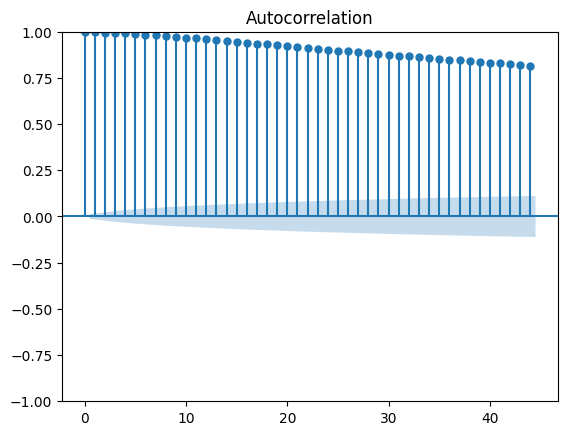

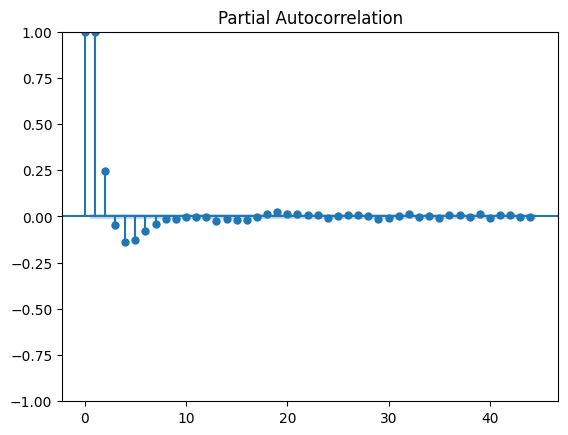

In [ ]:
# ACF и PACF
plot_acf(data['value'])
plot_pacf(data['value'])
plt.show()


Проведём преобразования для придания ряду стационарности

p-значение после дифференцирования: 0.0/n


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


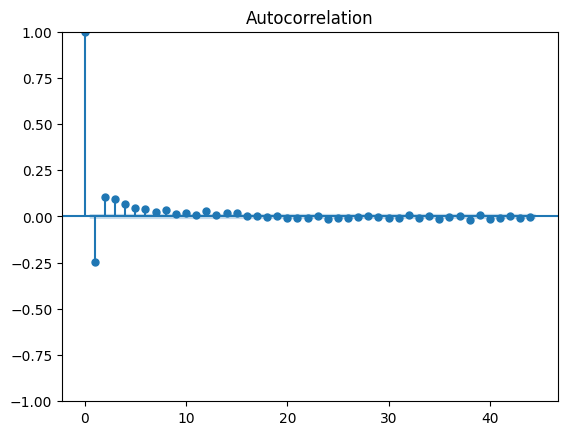

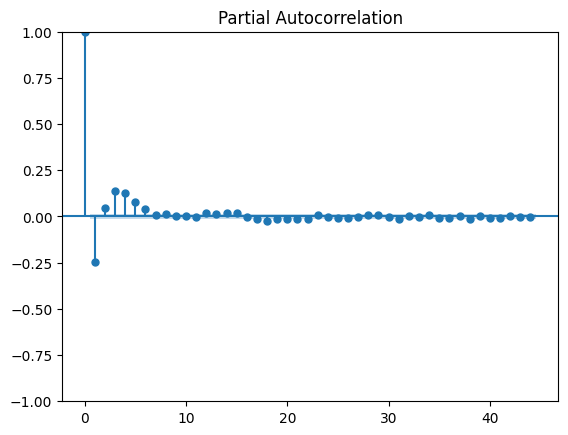

In [ ]:
data_diff = data['value'].diff().dropna()
result_diff = adfuller(data_diff)
print(f'p-значение после дифференцирования: {result_diff[1]}/n')
plot_acf(data_diff)
plot_pacf(data_diff)
plt.show()

Обучим модель ARIMA для прогнозирования значений ряда

In [ ]:
# Модель ARIMA
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['value'], order=(8, 0, 7))
model_fit = model.fit()
preds = model_fit.forecast(len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Визуализируем модель ARIMA и произведём замеры качества

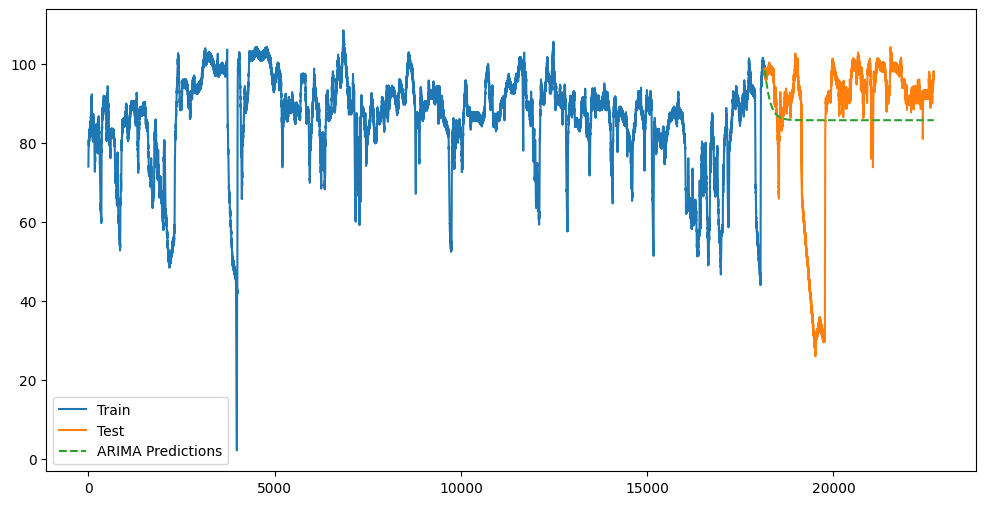

SMAPE ARIMA: 9.048392336003392


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['value'], label='Train')
plt.plot(test.index, test['value'], label='Test')
plt.plot(test.index, preds, label='ARIMA Predictions', linestyle='--')
plt.legend()
plt.show()

smape_arima = smape(test['value'], preds)
print(f'SMAPE ARIMA: {smape_arima}')

## Классическая модель

Используем Feature-Engineering для создания признаков

In [ ]:
# Feature Engineering
data['lag1'] = data['value'].shift(1)
data['rolling_mean'] = data['value'].rolling(window=3).mean()
data = data.dropna()

На полученном наборе данных обучим случайный лес

In [ ]:
# Train/Test Split для Random Forest
train_features = data.iloc[:train_size]
test_features = data.iloc[train_size:]

# Обучение случайного леса
rf = RandomForestRegressor(random_state=42)
rf.fit(train_features[['lag1', 'rolling_mean']], train_features['value'])

# Предсказания
rf_preds = rf.predict(test_features[['lag1', 'rolling_mean']])

Визуализируем результаты работы модели, произведём замеры качества модели

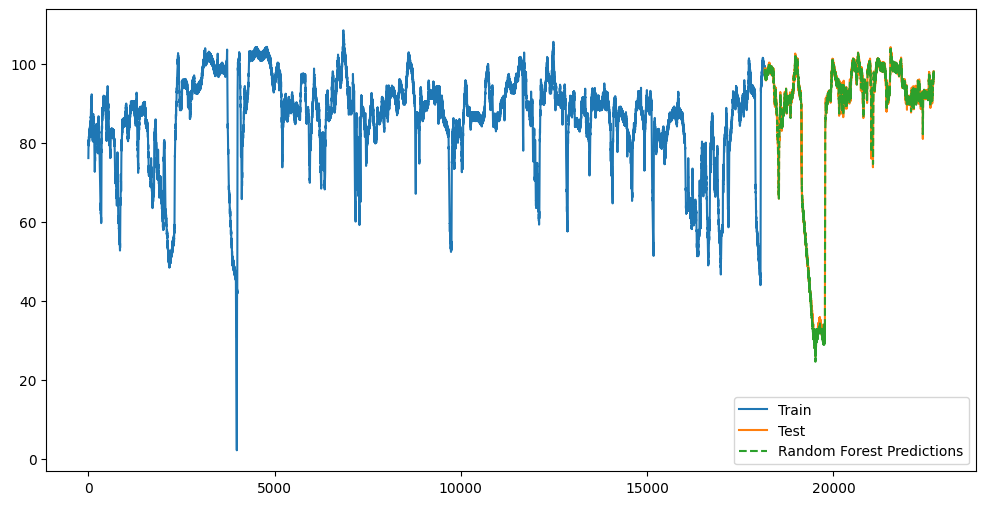

SMAPE Random Forest: 0.4171318509343482


In [ ]:
# Визуализация результатов Random Forest
plt.figure(figsize=(12, 6))
plt.plot(train_features.index, train_features['value'], label='Train')
plt.plot(test_features.index, test_features['value'], label='Test')
plt.plot(test_features.index, rf_preds, label='Random Forest Predictions', linestyle='--')
plt.legend()
plt.show()

# Замеры качества Random Forest
smape_rf = smape(test_features['value'], rf_preds)
print(f'SMAPE Random Forest: {smape_rf}')

# Нейросетевая модель

In [ ]:
# !pip install etna[all] -U

Обучим на выбранном временном ряду модель RNNModel из библиотеки ETNA

In [ ]:
df = load_data('machine_temperature_system_failure.csv')
df = df.rename(columns={'timestamp': 'timestamp', 'value': 'target'})
df['segment'] = 'main'
df = df.drop_duplicates(subset='timestamp', keep='first')
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq='5T')
ts.head()

segment,main
feature,target
timestamp,
2013-12-02 21:15:00,73.967322
2013-12-02 21:20:00,74.935882
2013-12-02 21:25:00,76.124162
2013-12-02 21:30:00,78.140707
2013-12-02 21:35:00,79.329836


In [ ]:
HORIZON = 7
model_rnn = RNNModel(
    decoder_length=HORIZON,
    encoder_length=2 * HORIZON,
    input_size=11,
    trainer_params=dict(max_epochs=4),
    lr=1e-3,
)

num_lags = 10
transform_lag = LagTransform(
    in_column='target',
    lags=[HORIZON + i for i in range(num_lags)],
    out_column='target_lag'
)

pipeline_rnn = Pipeline(
    model=model_rnn,
    horizon=HORIZON,
    transforms=[StandardScalerTransform(in_column="target"), transform_lag],
)
metrics = [SMAPE(), MAPE(), MAE()]
metrics_rnn, forecast_rnn, fold_info_rnn = pipeline_rnn.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | 

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  2.9min
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  5.7min
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  8.6min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  8.6min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.9s


Визуализируем модель и произведём замер качества

Усредненное значение SMAPE для LSTM: 0.808


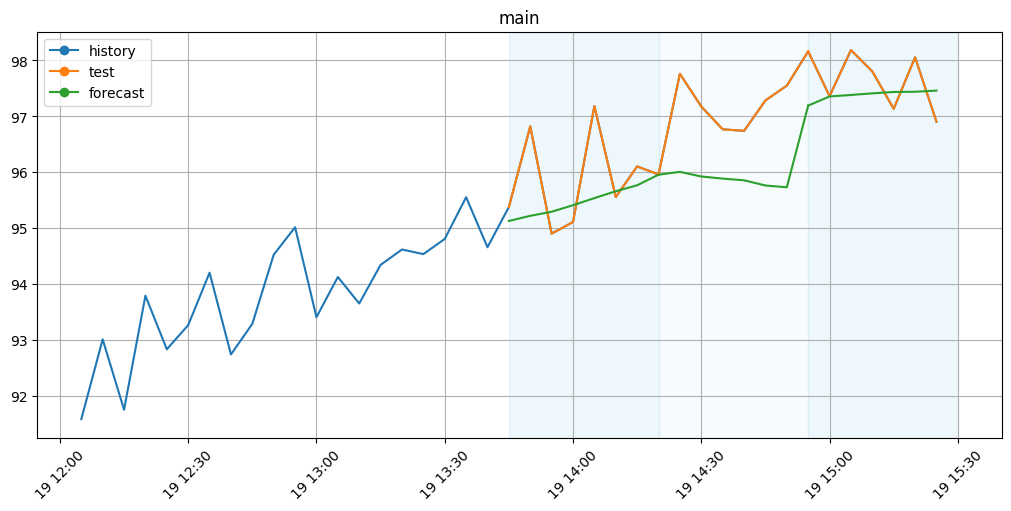

In [ ]:
smape_rnn = metrics_rnn["SMAPE"].mean()
print(f"Усредненное значение SMAPE для LSTM: {smape_rnn:.3f}")
plot_backtest(forecast_rnn, ts, history_len=20)

Обучим на выбранном временном ряду модель DeepAR с Feaure-Engineering из библиотеки ETNA

In [ ]:
transform_date = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=False,
    out_column='dateflag'
)

num_lags = 10
transform_lag = LagTransform(
    in_column='target',
    lags=[HORIZON + i for i in range(num_lags)],
    out_column='target_lag'
)
lag_columns = [f'target_lag_{HORIZON+i}' for i in range(num_lags)]

dataset_builder_deepar = PytorchForecastingDatasetBuilder(
    max_encoder_length=HORIZON,
    max_prediction_length=HORIZON,
    time_varying_known_reals=['time_idx'] + lag_columns,
    time_varying_unknown_reals=['target'],
    time_varying_known_categoricals=['dateflag_day_number_in_week'],
    target_normalizer=GroupNormalizer(groups=['segment']),
)

model_deepar = DeepARModel(
    dataset_builder=dataset_builder_deepar,
    trainer_params=dict(max_epochs=4, gpus=0, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64
)

pipeline_deepar = Pipeline(
    model=model_deepar,
    horizon=HORIZON,
    transforms=[transform_lag, transform_date]
)

metrics_deepar, forecast_deepar, _ = pipeline_deepar.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

<ipython-input-25-57d4b340bffa>:24: DeprecationWarning: Call to deprecated class DeepARModel. (DeepARModel is deprecated. Use DeepARNativeModel instead.) -- Deprecated since version 3.0.
  model_deepar = DeepARModel(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved d

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:83: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
INFO:pytorc

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  4.4min
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  6.6min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  6.6min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   10.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   14.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   14.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.7s


Визуализируем модель и произведём замер качества

Усредненное значение SMAPE для DeepAR с FE: 1.066


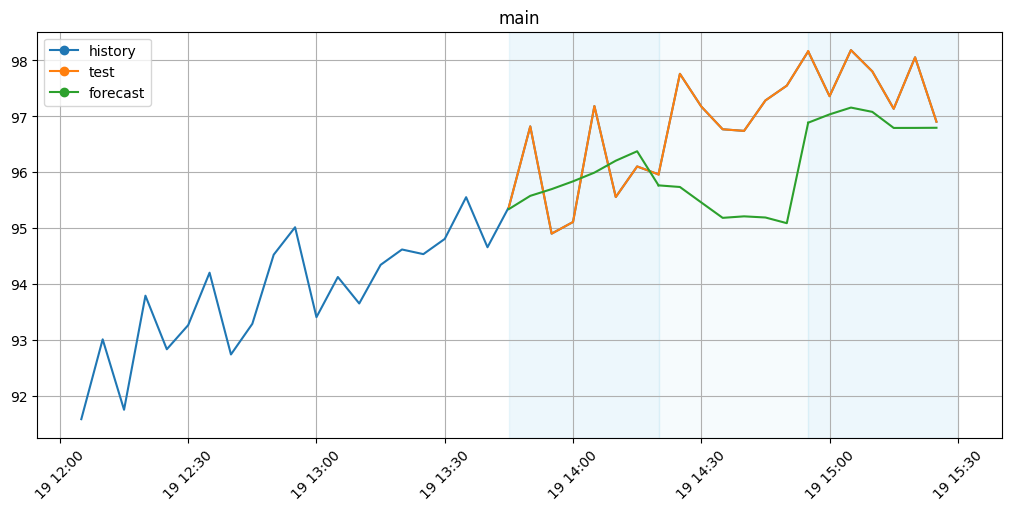

In [ ]:
smape_deepar = metrics_deepar['SMAPE'].mean()
print(f"Усредненное значение SMAPE для DeepAR с FE: {smape_deepar:.3f}")
plot_backtest(forecast_deepar, ts, history_len=20)

## Соберём метрики по всем моделям и сравним

In [ ]:
# Сбор метрик
metrics = pd.DataFrame({
    'Model': ['Baseline', 'ARIMA', 'Random Forest', 'RNN', 'DeepAR'],
    'SMAPE': [smape_baseline, smape_arima, smape_rf, smape_rnn, smape_deepar]
})

print(metrics)

           Model     SMAPE
0       Baseline  8.002128
1          ARIMA  9.048392
2  Random Forest  0.417132
3            RNN  0.808042
4         DeepAR  1.065891


## Выводы:

1. Random Forest: Наименьшее значение SMAPE (0.417132) указывает на его высокую точность в прогнозировании. Эта модель явно является наиболее эффективной среди представленных.

2. RNN: Значение SMAPE (0.808042) показывает, что RNN также демонстрирует неплохие результаты, но всё же уступает Random Forest.

3. DeepAR: Значение SMAPE (1.065891) немного хуже, чем у RNN, но всё же значительно лучше Baseline и ARIMA.

4. Baseline: Значение SMAPE (8.002128) служит отправной точкой для сравнения. Оно значительно выше, чем у Random Forest и других моделей, что указывает на необходимость улучшения.

5. ARIMA: Наивысшее значение SMAPE (9.048392) говорит о том, что эта модель неэффективна для данной задачи и требует пересмотра подхода или настройки параметров.

## Общий вывод:

Random Forest является наиболее эффективной моделью для прогнозирования в данной задаче, обеспечивая наименьшую ошибку по метрике SMAPE. Модели RNN и DeepAR также показывают приемлемые результаты, но не достигают уровня Random Forest. ARIMA продемонстрировала наихудшие результаты и требует дальнейшего анализа или доработки для повышения точности прогнозов.;